# Analyse des prénoms en France depuis 1900, par département

Le site data.gouv.fr propose un grand nombre de fichiers volumineux de données publiques, qui ne demandent qu'à être étudiés.
Ici, nous jetons un œil aux prénoms officiellement attribués à la naissance en France, par département (hors Mayotte), depuis 1900. Le fichier est accessible à l'adresse suivante : https://www.data.gouv.fr/fr/datasets/ficher-des-prenoms-de-1900-a-2018/ <br/><br/>
Nous l'analyserons via le langage Python et ses modules d'analyse statistique.

## Sommaire
<i>Note : Github ne prend pas ces liens en charge. Pour les faire fonctionner, copiez le lien de la page Web actuelle et collez-le dans la page </i><a href="https://nbviewer.jupyter.org/">https://nbviewer.jupyter.org/</a>
* <a href='#zeroth-bullet'>Importation et infos de base</a>
* <a href='#first-bullet'>Nettoyage</a>
* <a href='#second-bullet'>Exploration : on s'amuse comme on peut</a>
    * <a href='#third-bullet'>Exploration numérique</a>
    * <a href='#fourth-bullet'>Exploration graphique</a>
* <a href='#fifth-bullet'>Machine Learning</a>

## Importation et infos de base <a id="zeroth-bullet"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Importons le fichier téléchargé. <i>Ce CSV n'est pas délimité par des virgules</i>.

In [2]:
prenoms = pd.read_csv("dpt2018.csv", delimiter=";")

Commençons par regarder à quoi il ressemble.

In [3]:
bold = '\033[1m'
n_bold = '\033[0m'
print(bold + "Forme : "+ n_bold + str(prenoms.shape) + "\n")
print(bold + "Infos : " + n_bold)
print(prenoms.info(memory_usage='deep'))
print(bold + "\nPremières lignes :" + n_bold)
print(prenoms.head())

Forme : (3624994, 5)

Infos : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3624994 entries, 0 to 3624993
Data columns (total 5 columns):
sexe        int64
preusuel    object
annais      object
dpt         object
nombre      int64
dtypes: int64(2), object(3)
memory usage: 701.0 MB
None

Premières lignes :
   sexe preusuel annais dpt  nombre
0     1        A   XXXX  XX      27
1     1    AADAM   XXXX  XX      27
2     1    AADEL   XXXX  XX      55
3     1    AADIL   1983  84       3
4     1    AADIL   1992  92       3


## Nettoyage <a id="first-bullet"></a>
Le fichier contient donc plus de 3 600 000 lignes pour 5 colonnes : sexe, prénom usuel, année de naissance, département et nombre. <br/>
De prime abord, il y a plusieurs détails à éclaircir. Regardons les deux principaux. <br/>
<ol> 
    <li>D'une part, si le "1" dans la colonne "sexe" désigne vraisemblablement des individus masculins, quelle est la valeur pour le sexe féminin ? 0 ? 2 ? (C'est évidemment indiqué dans le dictionnaire des variables associé au fichier, mais jouons le jeu) </li>
    <li>Ensuite, on remarque des données non renseignées dans les colonnes "annais" et "dpt", qui ne sont ainsi pas des colonnes numériques. L'explication est fournie dans la documentation associée : pour être retenu, un prénom doit
        <ul>
        <li>avoir été donné au moins 20 fois à des personnes de sexe féminin ou 20 fois à des personnes de sexe masculin entre 1900 et 1945 .</li> 
        <li>avoir été donné au moins 20 fois à des personnes de sexe féminin ou 20 fois à des personnes de sexe masculin entre 1946 et 2018 .</li>     
        <li>avoir été donné au moins 3 fois à des personnes de sexe féminin ou de sexe masculin au cours d'une année donnée pour figurer dans cette année.</li>     
            </ul>
    </li>
</ol>

Répondons à la première question.

In [4]:
prenoms[prenoms.preusuel == "JACQUELINE"].head()

,sexe,preusuel,annais,dpt,nombre
2544883,2,JACQUELINE,1900,20,3
2544884,2,JACQUELINE,1900,33,3
2544885,2,JACQUELINE,1900,75,23
2544886,2,JACQUELINE,1900,77,3
2544887,2,JACQUELINE,1901,20,5


Manifestement, 1 vaut pour masculin et 2 pour féminin. Nous allons rendre la chose plus explicite. Créons une nouvelle DataFrame pour garder "prenoms" intacte.

In [5]:
cln_pren = prenoms.copy()
cln_pren.sexe = cln_pren.sexe.map({1:"M",2:"F"})

In [6]:
cln_pren.head()

,sexe,preusuel,annais,dpt,nombre
0,M,A,XXXX,XX,27
1,M,AADAM,XXXX,XX,27
2,M,AADEL,XXXX,XX,55
3,M,AADIL,1983,84,3
4,M,AADIL,1992,92,3


Au fait, quelle est le pourcentage de lignes qui comportent une année de naissance non renseignée ?

In [7]:
100 * cln_pren[cln_pren.annais=="XXXX"].annais.count() / len(cln_pren)

0.9822912810338444

Moins de 1%. Ouf. Pour la suite de notre analyse, nous ne nous intéresserons qu'aux prénoms dont l'année de naissance est connue.

In [8]:
cln_pren = cln_pren[cln_pren.annais !='XXXX']
cln_pren['annais'] = cln_pren['annais'].astype(int) #convertissons les années en entiers

#Reste-t-il alors des départements non renseignés ?
print(cln_pren.dpt[cln_pren.dpt=="XX"].count())

0


Après ce ménage, y a-t-il des données absentes ?

In [9]:
cln_pren.isna().sum()

sexe        0
preusuel    0
annais      0
dpt         0
nombre      0
dtype: int64

Non. Autre chose à savoir ? <br/>
Oui. Nous traitons ici du fichier avec les départements (qui nous seront utiles par la suite). <br/><br/>La manipulation de données ne vaut rien si on n'en maîtrise pas le contexte. 
Une personne non avertie pourrait s'étonner en dressant le graphique du nombre de prénoms donnés dans le département 75 depuis 1900 :

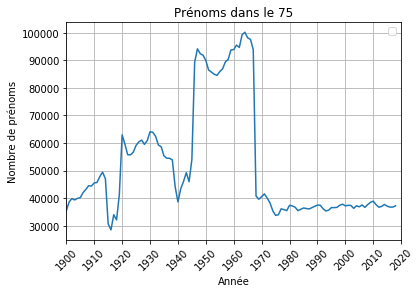

In [10]:
ax = cln_pren[cln_pren.dpt == "75"].pivot_table('nombre', index='annais', aggfunc='sum')\
.plot(xticks=np.arange(1900,2030,10), rot=45, grid=True, title='Prénoms dans le 75')
ax.set_xlabel("Année")
ax.set_ylabel("Nombre de prénoms")
ax.legend("");

Bien évidemment, nous retrouvons les creux correspondants aux deux guerres mondiales. <br/><br/>
<i><b>Mais on n'a jamais entendu parler du génocide parisien des années 60.</b> L'arrivée de la pilule a-t-elle été si efficace ?</i> <br/><br/>
En fait, il faut savoir que la <b>région parisienne a subi une réorganisation, effective en 1968</b>. Auparavant, le 75 désignait le département de la <i><b>Seine</b></i> qui, en plus de <b>Paris</b>, contenait les <b>Hauts-de-Seine</b>, la <b>Seine-Saint-Denis</b> et le <b>Val-de-Marne</b> actuels (aujourd'hui respectivement 92, 93 et 94). <br/>
De même, le département 78, autrefois <i><b>Seine-et-Oise</b></i>, en plus des <b>Yvelines</b> actuelles contenait l'<b>Essonne</b> et le <b>Val-d'Oise</b> actuels (aujourd'hui respectivement 91 et 95).<br/><br/>
Il faudra en tenir compte, sans quoi les analyses seront faussées.<br/><br/>
Enfin, en parcourant les données on remarque la présence d'un "prénom" original : "_PRENOMS_RARES". Le fichier n'indique-t-il pas chaque prénom ? Nous l'avons dit plus tôt, il faut être attentif :

In [11]:
print("Prénoms dont le nombre vaut 1 ou 2 : \t" + str(len(cln_pren[cln_pren.nombre <= 2])))
print("Prénoms dont le nombre vaut 3 : \t" + str(len(cln_pren[cln_pren.nombre == 3])))

Prénoms dont le nombre vaut 1 ou 2 : 	0
Prénoms dont le nombre vaut 3 : 	701205


Le fichier ne répertorie de prénoms que s'ils apparaissent au moins 3 fois dans le département. Le pourcentage de "prénoms rares" est-il important ?

In [12]:
100 * cln_pren[cln_pren.preusuel=="_PRENOMS_RARES"].nombre.sum() / cln_pren.nombre.sum()

2.0465323228123067

2% des prénoms répertoriés sont rares : nous nous permettrons de nous en passer.

In [13]:
cln_pren = cln_pren[cln_pren['preusuel'] != "_PRENOMS_RARES"]

## Exploration : on s'amuse comme on peut <a id="second-bullet"></a>
### Exploration numérique <a id="third-bullet"></a>
Et si nous commencions par regarder combien de prénoms uniques il existe (hors prénoms rares, puisqu'il ne nous est pas possible d'identifier leurs doublons) ?

In [14]:
cln_pren.preusuel.nunique()

14809

Quelles infos a-t-on sur le nombre de naissances par an ?

In [15]:
nb_VS_an = cln_pren.pivot_table('nombre', index='annais', aggfunc='sum')
nb_VS_an.nombre.describe()

count       119.000000
mean     632809.865546
std      137271.979743
min      260720.000000
25%      550878.500000
50%      616597.000000
75%      726324.500000
max      861269.000000
Name: nombre, dtype: float64

<ul>
    <li>La <b>moyenne</b> est de presque 633&nbsp;000 naissances par an, soit 1% de la taille de population de la fin du XXe siècle.</li>
    <li>La <b>médiane</b> n'est pas si éloignée (ce qui laisse penser que les extrêmes se compensent à peu près) : la moitié des années, il y avait plus de 616&nbsp;597 naissances. Comme la médiane est inférieure à la moyenne, c'est que cette dernière est influencée par des extrêmes hauts plus importants. </li>
    <li>En effet, un quart des années voit moins de 550&nbsp;887 naissances (<b>premier quartile</b> : 60&nbsp;000 de moins que la médiane), tandis qu'un autre quart voit plus de 726 324 naissances (<b>troisième quartile</b> : 110&nbsp;000 de plus que la médiane).</li>
    <li>La valeur <b>minimale</b> est très basse par rapport à la moyenne : de toute évidence, elle a un rapport avec la guerre.</li>
    <li>L'année de la valeur <b>maximale</b> est moins évidente : elle survient probablement lors du baby boom.</li>    
</ul>    
Étudions de plus près ces deux dernières valeurs :

In [16]:
print(bold + "Année avec le moins de naissances : " + n_bold)
print(nb_VS_an[nb_VS_an.nombre == nb_VS_an.nombre.min()].index[0])
print(bold + "Année avec le plus de naissances : " + n_bold)
print(nb_VS_an[nb_VS_an.nombre == nb_VS_an.nombre.max()].index[0])

Année avec le moins de naissances : 
1916
Année avec le plus de naissances : 
1947


Effectivement, le nombre le plus bas de naissances se trouve au milieu de la Première Guerre mondiale, et le nombre le plus élevé au tout début du baby boom.

Poursuivons l'exploration : quels sont les <b>10 prénoms les plus populaires</b> depuis 1900 ?

In [17]:
cln_pren.pivot_table('nombre', index=['preusuel'], aggfunc='sum')\
    .sort_values(by='nombre',ascending=False).head(10)

,nombre
preusuel,
MARIE,2257245
JEAN,1915736
PIERRE,891241
MICHEL,818024
ANDRÉ,709716
JEANNE,553559
PHILIPPE,535274
LOUIS,515966
RENÉ,514685


In [18]:
100 * cln_pren[cln_pren.preusuel=="MARIE"].nombre.sum() / cln_pren.nombre.sum()

2.997495205258595

Le prénom Marie arrive loin devant, suivie de 8 prénoms masculins et 1 féminin. Quasiment 3% des françaises depuis 1900 se sont fait nommer Marie. Quoique ?

In [19]:
100 * cln_pren.pivot_table('nombre', index=['preusuel','sexe'], aggfunc='sum').unstack()\
.query('preusuel == "MARIE"').nombre.eval('M/F')[0]

1.0839936069186433

Eh oui, 1% des Marie sont des garçons. Cela dit, ce nombre n'influence quasiment pas le précédent.<br/>
D'après le top 10 ci-dessus, nous connaissons le top 5 garçons, mais pas le <b>top 5 filles depuis 1900</b> :

In [20]:
cln_pren[cln_pren.sexe == "F"].pivot_table('nombre', index=['preusuel'], aggfunc='sum')\
    .sort_values(by='nombre',ascending=False).head(5)

,nombre
preusuel,
MARIE,2233039
JEANNE,553550
FRANÇOISE,399542
MONIQUE,397821
CATHERINE,391564


Les choses ont dû changer depuis les années 90 : dressons un <b>top 10</b> qui parlera plus au lecteur contemporain.

In [21]:
cln_pren[cln_pren['annais'] >= 1990].pivot_table('nombre', index=['preusuel'], aggfunc='sum')\
    .sort_values(by='nombre',ascending=False).head(10)

,nombre
preusuel,
THOMAS,178114
CAMILLE,167021
LUCAS,163771
MANON,159999
LÉA,159498
MAXIME,150222
ALEXANDRE,144243
CHLOÉ,132644
HUGO,131722


Par quelle lettre commencent généralement les prénoms répertoriés, indépendamment de leur popularité ?

In [22]:
s_prem_lettre = pd.Series(cln_pren.preusuel.unique()).apply(lambda s : s[0])
print(s_prem_lettre.value_counts().head(10))

M    1853
A    1670
S    1217
L    1047
E     741
C     740
J     723
N     676
K     667
R     621
dtype: int64


Autre curiosité, si nous avons un prénom (et éventuellement une année), dans quel département est probablement née la personne qui porte ce prénom ?<br/>
<b><i>Il sera plus parlant de nommer les départements</i></b>. Comme nous sommes <strike>feignants</strike> méthodiques, nous avons trouvé sur Internet une <b>liste brute de noms de départements associés à leur numéro</b>.

In [23]:
dpts = pd.read_csv("dpt.txt", delimiter="\t", encoding = "ISO-8859-1", names=['dpt','nom_dpt'],\
                   dtype={'numero': str}) #Comme notre dataframe cln_pren
dpts.head(4)

,dpt,nom_dpt
0,01,Ain
1,02,Aisne
2,03,Allier
3,04,Alpes-de-Haute-Provence


In [24]:
merged = pd.merge(cln_pren, dpts, how='left', on='dpt')
#Désolé les Corses, le fichier de prénoms ne discrimine pas Corse-du-Sud et Haute-Corse
merged.loc[merged.dpt=="20", 'nom_dpt'] = "Corse"
#On n'oublie pas la réforme de 1968
merged.loc[(merged.annais < 1968)&(merged.dpt == "75"), 'nom_dpt'] = "Seine"
merged.loc[(merged.annais < 1968)&(merged.dpt == "78"), 'nom_dpt'] = "Seine-et-Oise"

merged.isnull().any()

sexe        False
preusuel    False
annais      False
dpt         False
nombre      False
nom_dpt     False
dtype: bool

In [25]:
def dpt_pren(prenom, annee=None):
    prenom = prenom.upper()
    if not annee:
        nb_VS_dpt = merged.query('preusuel == @prenom')\
        .pivot_table('nombre', index='nom_dpt', aggfunc='sum')
    else:
        nb_VS_dpt = merged.query('preusuel == @prenom and annais == @annee')\
        .pivot_table('nombre', index='nom_dpt', aggfunc='sum')
    if nb_VS_dpt.empty:
        print("Prénom inexistant ou année incorrecte")
        return
    total_pren = nb_VS_dpt.nombre.sum()
    prct = (100 * nb_VS_dpt.nombre.sort_values(ascending=False) / total_pren).head(5)
    if annee:
        print("En {}".format(annee), end=', ')
    print("Les %s%s%s sont principalement né.e.s dans les départements suivants: "\
              % (bold, prenom.capitalize(), n_bold))
    cumul = 0
    for dpt, pourcent in prct.iteritems():
        rnd_prct = round(pourcent, 2)
        print("{}{}{} : à {} %".format(bold, dpt, n_bold, rnd_prct))
        cumul += rnd_prct
    cumul = round(cumul,2) #Devrait être inutile, mais round présente des imperfections
    print("Cumul : {} %\n".format(cumul)) 

In [26]:
print("Prénom breton ?")
dpt_pren("erwan", 1986)
print("Prénom du sud est ?")
dpt_pren("Giulia")
print("Prénom de sud ouest ?")
dpt_pren("enea")
print("Prénom du nord ?")
dpt_pren("kevin", 1990)
print("Prénom de l'est ?")
dpt_pren("walter")

Prénom breton ?
En 1986, Les Erwan sont principalement né.e.s dans les départements suivants: 
Finistère : à 11.93 %
Loire-Atlantique : à 9.33 %
Morbihan : à 8.46 %
Côtes d'Armor : à 6.51 %
Ille-et-Vilaine : à 6.29 %
Cumul : 42.52 %

Prénom du sud est ?
Les Giulia sont principalement né.e.s dans les départements suivants: 
Bouches-du-Rhône : à 10.58 %
Alpes-Maritimes : à 6.29 %
Paris : à 6.18 %
Nord : à 4.32 %
Rhône : à 4.13 %
Cumul : 31.5 %

Prénom de sud ouest ?
Les Enea sont principalement né.e.s dans les départements suivants: 
Pyrénées-Atlantiques : à 70.25 %
Gironde : à 7.67 %
Paris : à 6.44 %
Haute-Garonne : à 4.6 %
Hauts-de-Seine : à 1.84 %
Cumul : 90.8 %

Prénom du nord ?
En 1990, Les Kevin sont principalement né.e.s dans les départements suivants: 
Nord : à 6.15 %
Pas-de-Calais : à 3.47 %
Seine-St-Denis : à 3.18 %
Rhône : à 3.11 %
Paris : à 2.98 %
Cumul : 18.89 %

Prénom de l'est ?
Les Walter sont principalement né.e.s dans les départements suivants: 
Moselle : à 17.86 %
Nord

Nous remarquons que les résultats sont fortement influencés par la répartition inégale de la population. Les départements denséments peuplés (Nord, Paris...) faussent un peu la donne. D'aucuns diraient qu'il convient d'améliorer la fonction en pondérant par la quantité de prénoms donnés dans le département. Moi, je dis que le challenge, c'est important.

Explorons de manière un peu plus précise : faisons en sorte de connaître les prénoms masculin et féminin les plus populaires par année, pour un intervalle donné :

In [27]:
def prenoms_pop(annee_dep, annee_arriv=None):
    if not annee_arriv: #donnons la possibilité de ne renseigner qu'une année
        annee_arriv = annee_dep
    max_pre = cln_pren.query('@annee_dep <= annais <= @annee_arriv')\
                .groupby(['annais','sexe']).idxmax().nombre
    return cln_pren.loc[max_pre].sort_values(by=['annais','sexe'])\
                [['annais','sexe','preusuel']].to_string(index=False)



print(bold + "Prénoms les plus populaires entre 1900 et 1905" + n_bold)
print(prenoms_pop(1900, 1905))

print(bold + "\nPrénoms les plus populaires en 1910" + n_bold)
print(prenoms_pop(1910))

print(bold + "\nPrénoms les plus populaires en 1930" + n_bold)
print(prenoms_pop(1930))

print(bold + "\nPrénoms les plus populaires en 1950" + n_bold)
print(prenoms_pop(1950))

print(bold + "\nPrénoms les plus populaires en 1970" + n_bold)
print(prenoms_pop(1970))

print(bold + "\nPrénoms les plus populaires en 1990" + n_bold)
print(prenoms_pop(1990))

print(bold + "\nPrénoms les plus populaires entre 2010 et 2015" + n_bold)
print(prenoms_pop(2010, 2015))

print(bold + "\nPrénoms les plus populaires en 2018" + n_bold)
print(prenoms_pop(2018))

Prénoms les plus populaires entre 1900 et 1905
 annais sexe preusuel
   1900    F    MARIE
   1900    M    ANDRÉ
   1901    F    MARIE
   1901    M   MARCEL
   1902    F    MARIE
   1902    M  GEORGES
   1903    F    MARIE
   1903    M    ANDRÉ
   1904    F    MARIE
   1904    M    ANDRÉ
   1905    F    MARIE
   1905    M    ANDRÉ

Prénoms les plus populaires en 1910
 annais sexe preusuel
   1910    F    MARIE
   1910    M    ANDRÉ

Prénoms les plus populaires en 1930
 annais sexe    preusuel
   1930    F  JACQUELINE
   1930    M        JEAN

Prénoms les plus populaires en 1950
 annais sexe preusuel
   1950    F  MARTINE
   1950    M    ALAIN

Prénoms les plus populaires en 1970
 annais sexe preusuel
   1970    F    MARIE
   1970    M    DAVID

Prénoms les plus populaires en 1990
 annais sexe preusuel
   1990    F    MARIE
   1990    M    KEVIN

Prénoms les plus populaires entre 2010 et 2015
 annais sexe preusuel
   2010    F   LOUISE
   2010    M  GABRIEL
   2011    F     EMMA
   2011

Rassurons-nous donc, le conformisme ne connaît pas de frontières générationnelles.<br/><br/>

Mais peut-être qu'on avait de meilleures excuses au début du XXe siècle. Peut-être que les mœurs étaient différentes, qu'on ne pouvait pas donner tant de prénoms que ça ? <br/>
Intéressons-nous à la diversité des prénoms au fil des années.

In [28]:
nb_pr_VS_annee = cln_pren.pivot_table('preusuel', index='annais', aggfunc='nunique').preusuel
print('Diversité min\nAnnée : {}\nPrénoms uniques : {}'\
      .format(nb_pr_VS_annee.idxmin(),nb_pr_VS_annee.min()))
print('\nDiversité max\nAnnée : {}\nPrénoms uniques : {}'\
      .format(nb_pr_VS_annee.idxmax(),nb_pr_VS_annee.max()))

Diversité min
Année : 1916
Prénoms uniques : 949

Diversité max
Année : 2014
Prénoms uniques : 4594


La diversité moindre correspond au nombre de naissances le plus bas, tandis que la plus grande diversité s'est manifestée récemment, et non au pic du baby boom.
Un graphique nous aidera à y voir plus clair.
   
### Exploration graphique <a id="fourth-bullet"></a>
Mettons cette dernière question en suspens, le temps de regarder la distribution des naissances depuis 1900.

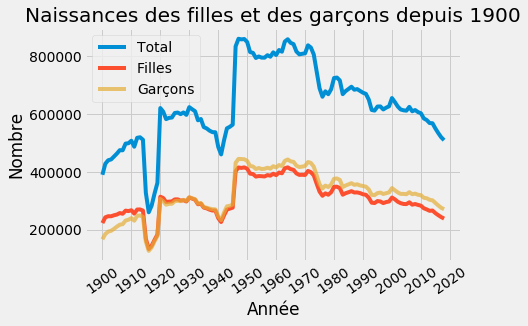

In [29]:
plt.style.use('fivethirtyeight')

groupe_tot = cln_pren.pivot_table('nombre', index=['annais'], aggfunc='sum')
plt.plot(groupe_tot.index, groupe_tot.nombre)

groupe_F = cln_pren[cln_pren.sexe == 'F'].pivot_table('nombre', index=['annais'], aggfunc='sum')
plt.plot(groupe_F.index, groupe_F.nombre)

groupe_M = cln_pren[cln_pren.sexe == 'M'].pivot_table('nombre', index=['annais'], aggfunc='sum')
plt.plot(groupe_M.index, groupe_M.nombre, alpha=0.7)

plt.title("Naissances des filles et des garçons depuis 1900")
plt.ylabel("Nombre")
plt.xlabel("Année")
plt.xticks(np.arange(1900,2030,10), rotation=35)
plt.legend(['Total','Filles','Garçons'])
plt.show()

On retrouve les creux relatifs aux deux guerres mondiales, ainsi que le baby-boom qui s'étend de la Seconde Guerre mondiale aux années 70, suivi d'une diminution des naissances d'abord nette au début des années 70 (arrivée de la pilule ? Choc pétrolier et instabilité monétaire ?), puis progressive jusqu'à aujourd'hui.<br/><br/>
Avec ce graphique en tête, nous pouvons revenir à l'étude de la diversité des prénoms, introduite au chapitre précédent.

Un plus grand nombre de naissances favorise une plus grande diversité de distribution des prénoms. Établissons des bases plus justes en dressant le graphique de la diversité en proportion au nombre de naissances.

Text(0, 0.5, 'nb prénoms / nb naissances')

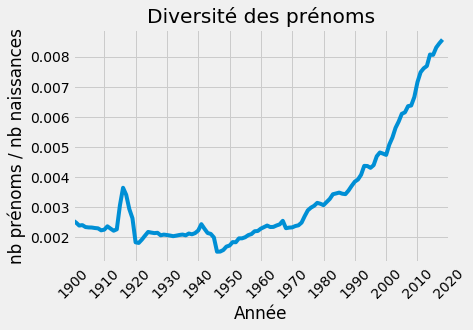

In [30]:
#nombre total de naissances par année
groupe_tot = cln_pren.pivot_table('nombre', index=['annais'], aggfunc='sum')

ax = (nb_pr_VS_annee/groupe_tot.nombre).plot(xticks=np.arange(1900,2030,10), rot=45, grid=True, \
                                       title="Diversité des prénoms")
ax.set_xlabel("Année")
ax.set_ylabel("nb prénoms / nb naissances")

 <ul>
    <li>Nous n'allons pas tenir compte des pics relatifs aux deux guerres mondiales, car le nombre de naissances diminuant drastiquement, ce n'est <i>a priori</i> pas tant le numérateur de notre opération (la diversité) qui augmente que le dénominateur (nombre de naissances) qui diminue.</li>
 <li>Étant donné que le baby-boom se traduit par une augmentation nette de la population, on s'attendrait à ce que la courbe diminue. Or, il n'en est rien : on retrouve une pente d'augmentation de plus en plus forte à partir du milieu des années 60.
 L'explication provient vraisemblablement de l'<b><i>instruction ministérielle du 12 avril 1966 (Journal officiel du 3 mai 1966)</i></b>, qui élargit les possibilités de prénoms : auparavant, seuls les noms des calendriers et des personnages connus étaient autorisés.</li>

Une fonction de répartion nous permettra de compléter l'analyse :

In [31]:
def distri_prenoms(*annees):
    cln_pren_an = cln_pren[cln_pren['annais'].isin(annees)]
    nb_VS_pren_an = cln_pren_an.pivot_table('nombre', index=['preusuel','annais'], aggfunc='sum')
    nb_VS_pren_an_unst = nb_VS_pren_an.unstack().fillna(0)
    
    for col in nb_VS_pren_an_unst:
        nb_VS_pren_an_unst[col] = 100*nb_VS_pren_an_unst[col]/nb_VS_pren_an_unst[col].sum()
        plt.hist(nb_VS_pren_an_unst[col], cumulative=True, density=1,\
                 bins=1000, histtype='step', linewidth=1.5)
    
    plt.title("Fonctions de répartition des prénoms pour les années : " \
              + ", ".join(list(map(str, annees))))

    plt.xlabel("% de fois qu'un prénom est donné")
    
    plt.ylim(0.9, 1.01)
    plt.ylabel("Densité")
    plt.legend(annees)
    plt.show()        

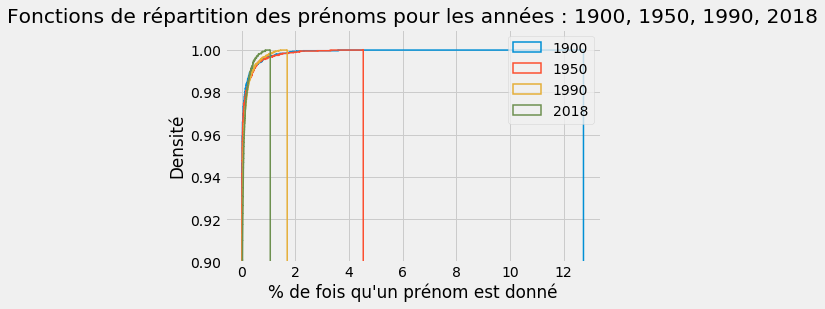

In [32]:
distri_prenoms(1900, 1950, 1990, 2018)

<ul>
    <li>Pour chaque année saisie, la densité d'approche très vite de 1 (les ordonnées commencent à 0.9 sur le graphique) : la plupart des prénoms sont donné peu de fois, ce qui n'est pas étonnant.</li>
    <li>Comme observé plus haut, la diversité augmente au fil du temps, car la densité max est atteinte de plus en plus tôt.</li>
    <li>On remarque particulièrement bien ici que les prénoms les plus populaires sont de plus en plus répartie : en 1900, plus de 12% des filles ont été nommées Marie.</li>
</ul><br/>
Comparons ce qui est comparable et gardons à l'esprit que la diversité a eu sa place à partir de 1968 :

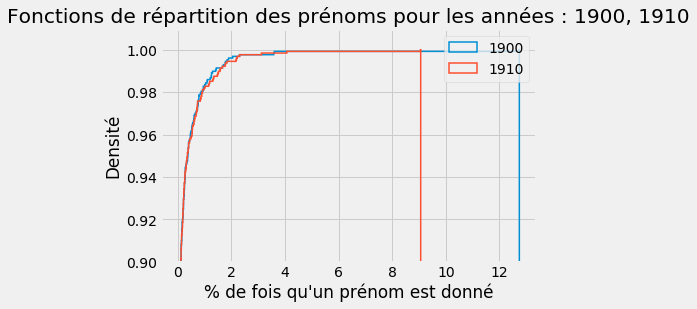

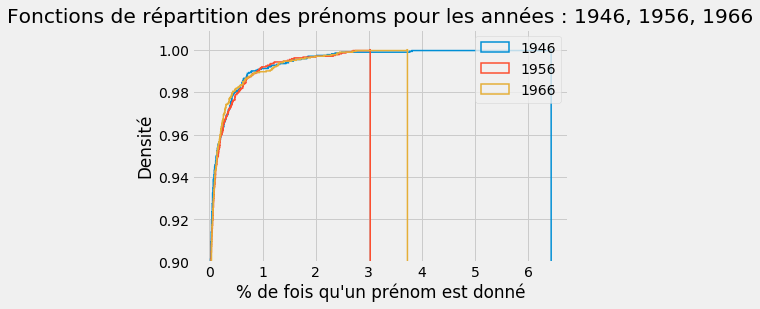

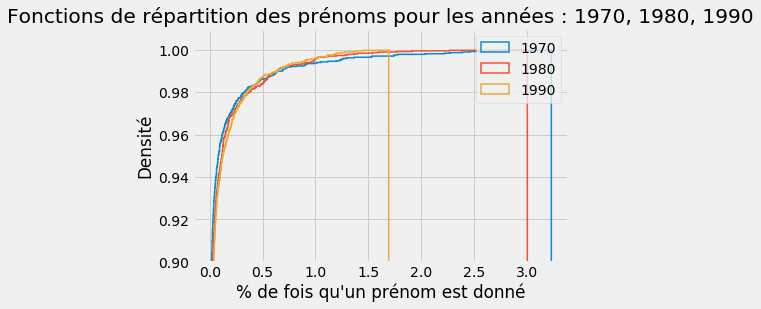

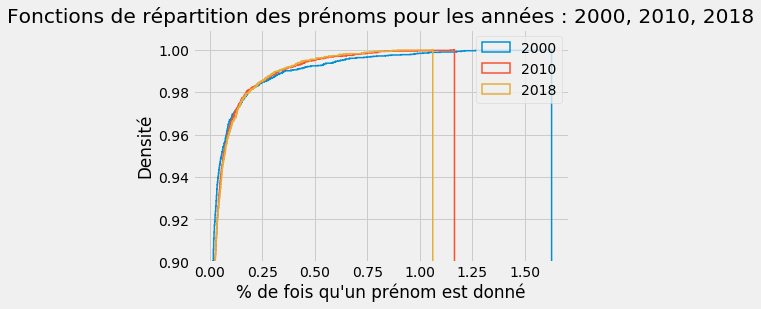

In [33]:
distri_prenoms(1900, 1910)
distri_prenoms(1946, 1956, 1966)
distri_prenoms(1970, 1980, 1990)
distri_prenoms(2000, 2010, 2018)

En conclusion, les mœurs changent peu sur 10 à 20 ans. Mais nous remarquons que le manque d'originalité apparent pour les prénoms donnés :
<ul>
    <li>avait l'excuse de la limite du <b>nombre de prénoms</b> qu'on pouvait donner avant 68</li>
    <li>n'est qu'une apparence aujourd'hui, car certes les prénoms les plus populaires conservent une tendance sur plusieurs années, mais ils sont <b>peu attribués en proportion</b> : ils sont donnés à 1% des nouveaux-nés <i>aujourd'hui, avec 510&nbsp;000 naissances</i>, contre 3% en <i>1980</i> (12 ans après l'instruction ministérielle), avec <i>725&nbsp;000 naissances</i>. C'est donc la génération de mes parents qui a le moins d'excuse. Quelle insouciance.</li>
</ul>

Une autre analyse graphique intéressante est celle de l'évolution de prénoms donnés au fil des années. Créons une fonction qui permet de comparer les courbes de plusieurs prénoms :

In [34]:
def graph_prenoms(*liste_prenoms):
    """Affiche les courbes des naissances correspondant à chaque prénom fourni en paramètre,
    en France hors Mayotte entre 1900 et 2018"""
    dict_df_pren = dict( (prenom, cln_pren[cln_pren.preusuel == prenom.upper()])
                        for prenom in liste_prenoms)
    #modifier un dict pendant l'itération mène à une erreur.
    #Listons les prénoms qu'on n'affichera pas :
    pren_introuvables = [] 
    for prenom, df_pre in dict_df_pren.items():
        if not df_pre.empty: 
            groupe = df_pre.groupby(['annais']).sum()
            plt.bar(groupe.index, groupe.nombre, alpha=0.7, width=1)
        else:
            print('Prénom introuvable : {}'.format(prenom))   
            pren_introuvables.append(prenom)
    for prenom in pren_introuvables:
        dict_df_pren.pop(prenom)
    if dict_df_pren.values():    #n'afficher un graph que s'il y a quelque chose à afficher
        plt.title("Naissances des : " 
                  + ', '.join([prenom.capitalize() 
                              for prenom,_ in dict_df_pren.items()]))
        plt.ylabel("Nombre")
        plt.xlabel("Année")
        plt.xticks(np.arange(1900,2030,10), rotation=35)
        plt.legend([prenom.capitalize() 
                    for prenom,_ in dict_df_pren.items()])
        plt.show()

Testons la fonction avec des prénoms dont on a une idée de l'époque de popularité :

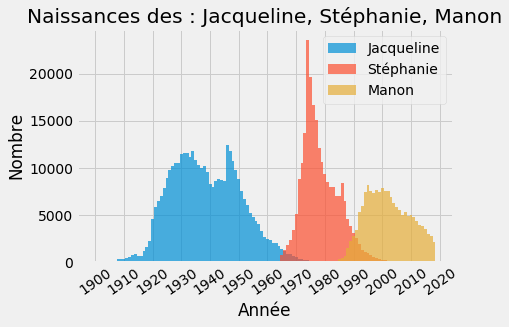

In [35]:
graph_prenoms('Jacqueline', 'Stéphanie', 'Manon')   

Revenons sur la mode actuelle des <b>Louise</b> et <b>Gabriel</b>, constatée lors de l'analyse numérique. Une personne de ma génération dirait probablement que ces prénoms n'étaient plus populaires depuis quelque temps. Vérifions :

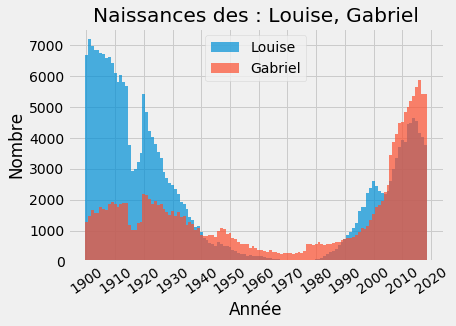

In [36]:
graph_prenoms('louise','gabriel')

On constate effectivement qu'après une longue récession, ces deux prénoms sont revenus à la mode, quoiqu'ils soient à nouveau en phase de diminution.<br/><br/>
Autre idée à explorer : les prénoms ne deviendraient-ils pas plus courts de manière générale ?

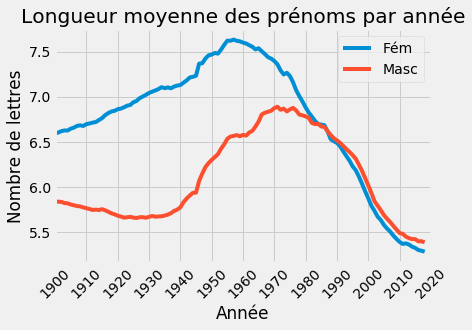

In [37]:
#Nouvelle colonne : taille du prénom. On ne la modifie pas, car on s'en sert après
cln_pren["taille_pren"] = cln_pren.preusuel.apply(lambda s : len(s))

#Pondérer chaque ligne par le nombre de fois que le prénom est donné
cln_pren["taille_pren_pond"] = cln_pren["taille_pren"] * cln_pren["nombre"]

t_nb_VS_an_sx = cln_pren.pivot_table(['taille_pren_pond','nombre'], index=['annais','sexe'],\
                                    aggfunc='sum')
                                    
#Terminer la pondération en divisant par le nombre total de prénoms donné
t_nb_VS_an_sx['taille_pren_pond'] = t_nb_VS_an_sx['taille_pren_pond'] / t_nb_VS_an_sx['nombre']

#Drop pour retirer "nombre", unstack pour afficher séparément Fém et Masc
ax = t_nb_VS_an_sx.drop('nombre', axis=1).unstack()\
        .plot(xticks=np.arange(1900,2030,10), rot=45, grid=True)

ax.set_title("Longueur moyenne des prénoms par année")
ax.set_xlabel("Année")
ax.set_ylabel("Nombre de lettres")
ax.legend(["Fém", "Masc"]);

#La colonne pondérée ne nous est plus utile
cln_pren.drop('taille_pren_pond', axis=1, inplace=True)

Ce n'est pas qu'une impression, la tendance à la diminution de la taille des prénoms est très nette. À propos, quels sont les prénoms les plus longs ?

In [38]:
[pren for pren in cln_pren.query('taille_pren == taille_pren.max()').preusuel]

['FRANÇOIS-GUILLAUME', 'PHILIPPE-ALEXANDRE']

Les prénoms composés, c'est de la triche :

In [39]:
[pren for pren in cln_pren[~cln_pren['preusuel'].str.contains('-')].query('taille_pren == taille_pren.max()').preusuel.unique()]

['ABDOURAHAMANE', 'JACQUEMINETTE']

In [40]:
#Allégeons la DataFrame
cln_pren.drop('taille_pren', axis=1, inplace=True)

Nous pouvons donc supposer que de même, la tendance des prénoms composés diminue.

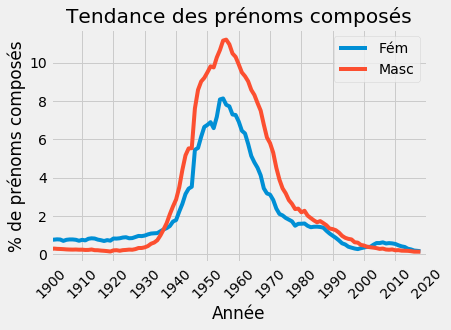

In [41]:
cln_pren["pren_comp"] = cln_pren.preusuel.str.contains("-")

#Pondérer. True est converti en 1, False en 0
cln_pren["pren_comp_pond"] = cln_pren["pren_comp"] * cln_pren["nombre"]

c_nb_VS_an_sx = cln_pren.pivot_table(['pren_comp_pond','nombre'], index=['annais','sexe'],\
                                    aggfunc='sum')
                                    
#Terminer la pondération en divisant par le nombre total de prénoms donné
c_nb_VS_an_sx['pren_comp_pond'] = 100 * c_nb_VS_an_sx['pren_comp_pond'] / c_nb_VS_an_sx['nombre']


ax = c_nb_VS_an_sx.drop('nombre', axis=1).unstack()\
    .plot(xticks=np.arange(1900,2030,10), rot=45, grid=True)

ax.set_title("Tendance des prénoms composés")
ax.set_xlabel("Année")
ax.set_ylabel("% de prénoms composés")
ax.legend(["Fém", "Masc"]);

cln_pren.drop('pren_comp', axis=1, inplace=True)
cln_pren.drop('pren_comp_pond', axis=1, inplace=True)

Pour comparer avec le graphique précédent, 
- le pic des prénoms composés correspond bien au pic de la longueur des prénoms. Les garçons ont alors plus de prénoms composés mais les filles ont des prénoms plus longs, ce qui n'est pas étonnant si on compare les équivalents (Daniel -> Danielle, Jean -> Jeanne).
- Toutefois, il y a aujourd'hui aussi peu de prénoms composés qu'au début du XXe siècle, qui comptait pourtant plus de lettres par prénom.<br/><br/>
Nous pouvons donc déduire en toute sécurité que les prénoms non composés d'aujourd'hui sont plus courts que les prénoms non composés du début du XXe siècle.


Sans transition, notons une "faille" dans ce fichier de données :

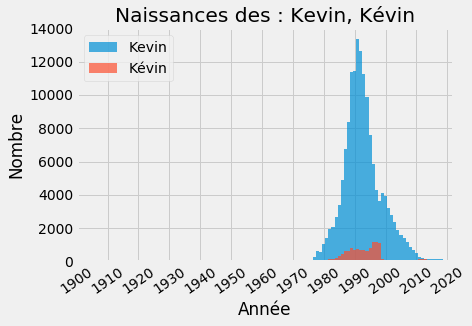

In [42]:
graph_prenoms('kevin','kévin')

Le fichier prend bel et bien en compte les accents sur les prénoms, mais cela signifie surtout qu'il nous faut être prudents lorsqu'on recherche un prénom dont il existe une variante avec accent.

Le problème se pose plus qu'il n'y paraît, comme nous allons le voir ci-après : écrivons une fonction qui détermine si un prénom est passé de 0 à une popularité soudaine d'une année sur l'autre. Le but original de la fonction est de <b>jouer à déterminer la cause de popularité du prénom</b> (nous y reviendrons !).<br/><br/>
<i>Cette fonction va sûrement prendre du temps à s'exécuter, associons-lui un timer pour vérifier.</i>

In [43]:
import time

#la recherche en dictionnaire prend moins de temps qu'un .loc
pop_tot_par_an = cln_pren.pivot_table('nombre', index='annais', aggfunc='sum').nombre.to_dict()

nb_VS_an_pren = cln_pren.pivot_table('nombre', index=['annais','preusuel'], aggfunc='sum')
#On ne s'intéresse qu'aux prénoms très populaires
pren_plus_pops = cln_pren.groupby('preusuel').sum().query('nombre>1000').nombre

start = time.time()
for prenom in pren_plus_pops.index:
    for year in np.arange(1901,2018):
        try: #Seules les années où le prénom existe sont valables
            nb_pr = nb_VS_an_pren.loc[(year,prenom)][0]
        except KeyError:
            continue    
        try: 
            nb_pr_1_an_avant = nb_VS_an_pren.loc[(year-1,prenom)][0]
        except KeyError: #On s'intéresse aux prénoms qui n'existaient pas l'année précédente
            if nb_pr > (0.0002 * pop_tot_par_an[year]):#donné à plus d'un enfant sur 5000
                print("%s : %d naissances, en %d" % (prenom, nb_pr, year))
                break
    
end = time.time() - start 
print("\nTemps écoulé : %d min %d secondes" % divmod(round(end), 60))


ADELE : 250 naissances, en 2010
ANAIS : 999 naissances, en 2010
ANAËLLE : 194 naissances, en 2010
ANDREA : 310 naissances, en 2010
CELIA : 601 naissances, en 2010
CHLOE : 1845 naissances, en 2010
CLEMENCE : 677 naissances, en 2010
CLEMENT : 1195 naissances, en 2010
CLOÉ : 124 naissances, en 2010
ELOÏSE : 182 naissances, en 2010
GAYLORD : 151 naissances, en 1980
ISMAËL : 158 naissances, en 2010
KAÏS : 181 naissances, en 2010
LAURIANE : 223 naissances, en 1977
LEA : 1892 naissances, en 2010
LEANA : 328 naissances, en 2010
LEANE : 336 naissances, en 2010
LENA : 1333 naissances, en 2010
LEO : 1711 naissances, en 2010
LEON : 210 naissances, en 2010
LEONIE : 599 naissances, en 2010
MATEO : 309 naissances, en 2010
MATHEO : 1258 naissances, en 2010
MATTEO : 599 naissances, en 2010
MAËL : 742 naissances, en 2010
MAËLLE : 269 naissances, en 2010
MAËVA : 146 naissances, en 2010
MAÏSSA : 180 naissances, en 2010
MELINA : 460 naissances, en 2010
MELISSA : 433 naissances, en 2010
MÉLINE : 141 naissan

Pour l'instant, le jeu semble tomber à l'eau. Analysons le résultat :
<ul>
    <li>Étonnant ! 2010 serait-elle l'année de toutes les nouvelles tendances ? Peu probable. Que s'est-il passé ? Étant donné l'allure des prénoms, soupçonnons une histoire d'accent : <b>voir ci-dessous</b>.</li>
    <li>Mention spéciale pour les Gaylord et les Lauriane, qui sortent du lot.</li>
    <li>Notre fonction n'est pas particulièrement drastique, car 124 naissances suffisent à générer un positif. Déduisons-en que les prénoms qui gagnent soudainement en popularité existaient déjà l'année précédente. </li>
</ul>

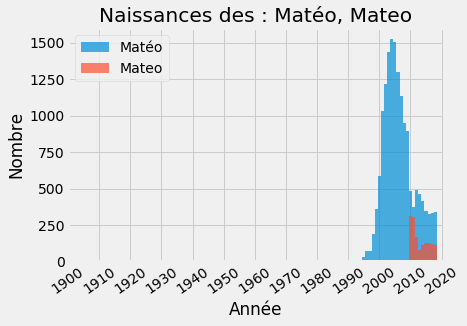

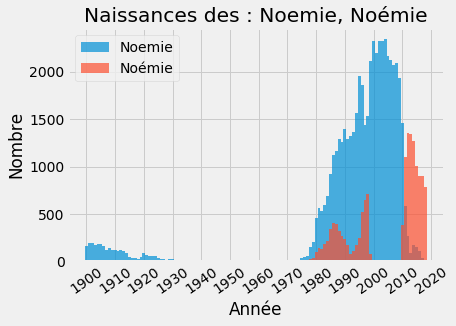

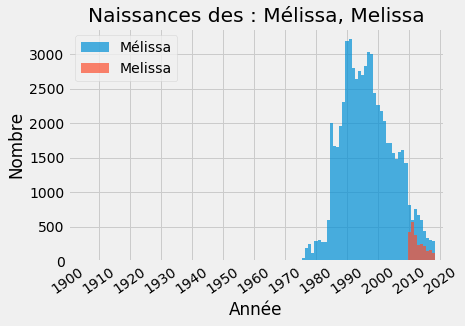

In [44]:
graph_prenoms('matéo', 'mateo')
graph_prenoms('noemie', 'noémie')
graph_prenoms('mélissa', 'melissa')

Il s'est apparemment passé quelque chose en 2010 vis-à-vis des accents sur certains prénoms. Certains prénoms déjà populaires ont perdu des accents, d'autres en ont gagné. <br/><br/>
<b><i>Serait-ce une erreur de saisie des données ? Mystère...</i></b>

Retentons de lancer le jeu : désormais, pour être <b><i>candidat à la tendance fulgurante</i></b>, le prénom doit exister, puis on lui laisse deux ans pour s'installer confortablement.<br/>

In [45]:
#le dictionnaire va réduire la durée de la boucle
pop_tot_par_an = cln_pren.pivot_table('nombre', index='annais', aggfunc='sum').nombre.to_dict()

nb_VS_an_pren = cln_pren.pivot_table('nombre', index=['annais','preusuel'], aggfunc='sum')
#On ne s'intéresse qu'aux prénoms très populaires
pren_plus_pops = cln_pren.groupby('preusuel').sum().query('nombre>800').nombre
start = time.time()
for prenom in pren_plus_pops.index:
    for year in np.arange(1902,2018):
        try:
            nb_pr_2_ans_avant = nb_VS_an_pren.loc[(year-2,prenom)][0]
            nb_pr = nb_VS_an_pren.loc[(year,prenom)][0]
            #Les nombres choisis sont purement arbitraires, dus à des essais successifs
            #Notons que ceci ne marche que si le nombre de naissances est comparable :
            if nb_pr_2_ans_avant > 5 \
            and nb_pr/pop_tot_par_an[year] > (nb_pr_2_ans_avant * 35 /pop_tot_par_an[year-2]):
                print("%s : %d naissances en %d, %d en %d " \
                      % (prenom, nb_pr_2_ans_avant, year-2, nb_pr, year))
                break
        except KeyError:
            continue
            
end = time.time() - start 
print("\nTemps écoulé : %d min %d secondes" % divmod(round(end), 60))

BRANDON : 18 naissances en 1991, 624 en 1993 
CINDY : 14 naissances en 1975, 1340 en 1977 
CYRIELLE : 7 naissances en 1980, 263 en 1982 
INES : 8 naissances en 2009, 2153 en 2011 
JORDY : 6 naissances en 1991, 1191 en 1993 
LANA : 18 naissances en 2002, 997 en 2004 
LUDIVINE : 7 naissances en 1972, 468 en 1974 
MANDY : 6 naissances en 1984, 217 en 1986 
MAËLYS : 6 naissances en 2009, 1662 en 2011 
PAMELA : 16 naissances en 1979, 1101 en 1981 
SOAN : 11 naissances en 2007, 596 en 2009 
YOANN : 12 naissances en 1972, 541 en 1974 

Temps écoulé : 2 min 38 secondes


<b>Voilà !</b> Avez-vous su déterminer l'origine de la popularité de ces prénoms ?
<ul>
    <li><b>Séries TV :</b> Gageons que <b>Brandon</b> doit sa popularité à l'arrivée de la série Berverly Hills fin 1990 (Brandon Walsh), et que <b>Lana</b> doit la sienne à la série Smallville née fin 2001 (Lana Lang).</li>
    <li><b>Pop-stars : Jordy</b> est un enfant-star, célèbre dès 1992 pour sa chanson "Dur dur d'être bébé". <b>Soan</b> provient sûrement du chanteur du même nom, vainqueur de l'émission la Nouvelle Star en 2009.</li>
    <li>Je vous laisse le soin de découvrir (et/ou de m'indiquer !) d'où vient la popularité des autres prénoms (éventuellement due au hasard).</li>
</ul>

<i>Note : nous pourrions envisager une fonction qui au contraire décèle les <b>baisses spectaculaires de popularité</b> d'un prénom, par exemple dues à une personnalité particulièrement impopulaire, mais ça ne fonctionne pas.<br/> Pas même pour l'impopularité la plus emblématique du XXe siècle pour la France, tel que ce graphique le laisse entendre :<i/>

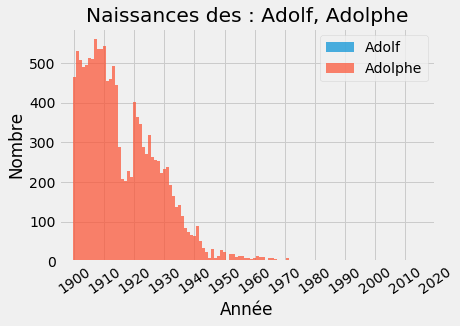

In [46]:
graph_prenoms('adolf','adolphe')

Testons d'autres pistes : la mode de la capitale influence-t-elle les autres départements ? <br/>
Nous ne regarderons qu'à partir de 1968, date à laquelle le 75 devient Paris. En outre, cette date a l'avantage d'être postérieure à l'instruction ministérielle mentionnée plus haut : de nouveaux prénoms apparaissent.

In [47]:
def grph_75_province(prenom):
    """Affiche les courbes des naissances correspondant aux proportions du prénom 
    fourni en paramètre par rapport à l'ensemble des prénoms donnés, 
    à Paris et dans les autres départements de France hors Mayotte entre 1968 et 2018"""
    #On s'intéresse à l'après 68, le 75 n'était pas Paris auparavant
    df_post_68 = cln_pren[cln_pren['annais'] >= 1968]
    #DataFrame contenant notre prénom 
    df_reference = df_post_68[df_post_68['preusuel']==prenom.upper()]
    paris = df_reference[df_reference.dpt == "75"]
    province = df_reference[df_reference.dpt != "75"]
    
    #DataFrame qui va déterminer la somme de tous les prénoms
    total_paris = df_post_68[df_post_68.dpt == "75"].nombre.sum()
    total_province = df_post_68[df_post_68.dpt != "75"].nombre.sum()
    
    if paris.empty or province.empty : 
        print('Prénom introuvable')
    else:
        groupe_paris = paris.groupby(['annais']).sum()
        plt.plot(groupe_paris.index, groupe_paris.nombre/total_paris, alpha=0.7)
        groupe_province = province.groupby(['annais']).sum()
        plt.plot(groupe_province.index, groupe_province.nombre/total_province, alpha=0.7)
        plt.title("Proportion de : " + prenom.capitalize())
        plt.ylabel("Proportion")
        plt.xlabel("Année")
        plt.xticks(np.arange(1968,2028,10), rotation=35)
        plt.legend(['À Paris','En Province'])
        plt.show()

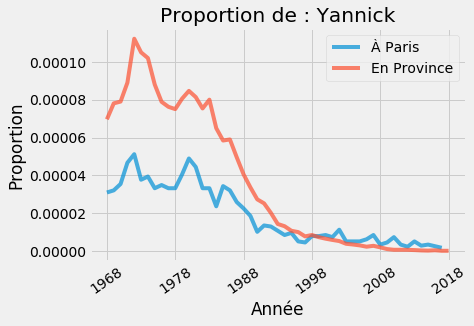

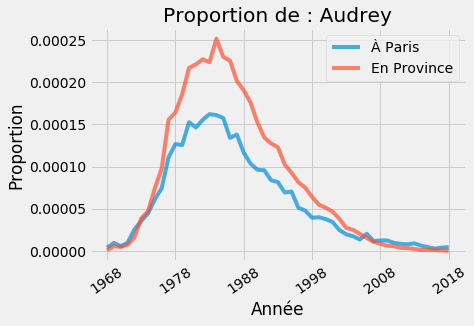

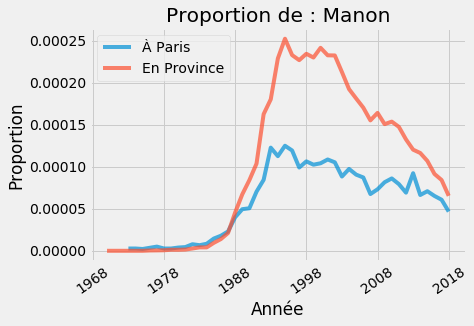

In [48]:
grph_75_province('yannick')
grph_75_province('audrey')
grph_75_province('manon')

La popularité d'un prénom semble toujours synchrone dans et hors Paris.<br/>
Et pour la France non métropolitaine ? 
Les codes 971, 972,  973 et 974 désignent respectivement <b>la Guadeloupe, la Martinique, la Guyane et La Réunion</b>.

In [49]:
def grph_metrop_97(prenom):
    """Affiche les courbes des naissances correspondant aux proportions du prénom 
    fourni en paramètre par rapport à l'ensemble des prénoms donnés, 
    à Paris et dans les autres départements de France hors Mayotte entre 1968 et 2018"""
    prenom = prenom.upper()
    #DataFrame contenant notre prénom 
    df_reference = cln_pren.query('preusuel == @prenom')
    fr_metr = df_reference[~df_reference.dpt.str.contains("97")]
    hors_metrop = df_reference[df_reference.dpt.str.contains("97")]
    
    #DataFrame qui va déterminer la somme des autres prénoms
    total_fr_metr = cln_pren[~cln_pren.dpt.str.contains("97")].nombre.sum()
    total_hors_metrop = cln_pren[cln_pren.dpt.str.contains("97")].nombre.sum()
    
    if fr_metr.empty or hors_metrop.empty : 
        print('Prénom introuvable')
    else:
        groupe_fr_metr = fr_metr.groupby(['annais']).sum()
        plt.plot(groupe_fr_metr.index, groupe_fr_metr.nombre/total_fr_metr, alpha=0.7)
        groupe_hors_metrop = hors_metrop.groupby(['annais']).sum()
        plt.plot(groupe_hors_metrop.index, groupe_hors_metrop.nombre/total_hors_metrop, alpha=0.7)
        plt.title("Proportion de : " + prenom.capitalize())
        plt.ylabel("Proportion")
        plt.xlabel("Année")
        plt.xticks(np.arange(1900,2030,10), rotation=35)
        plt.legend(['En France métropolitaine','En DOM'])
        plt.show()

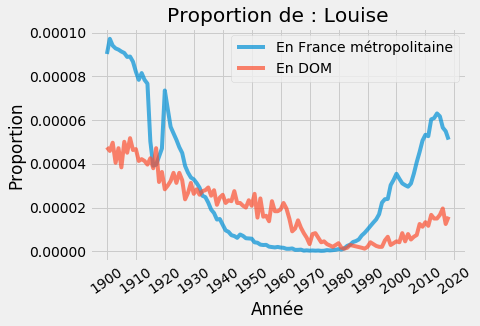

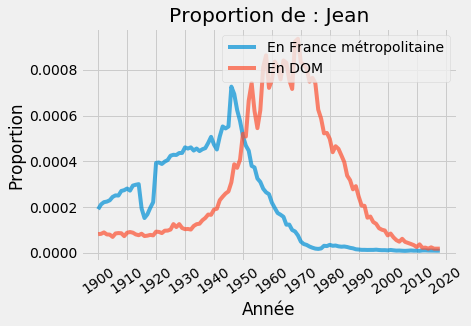

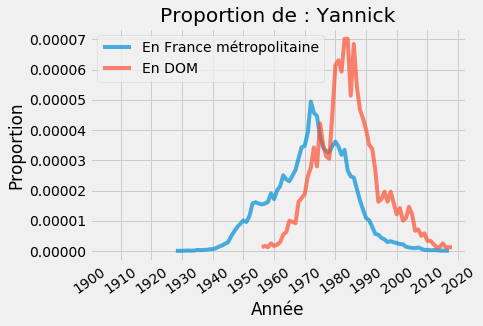

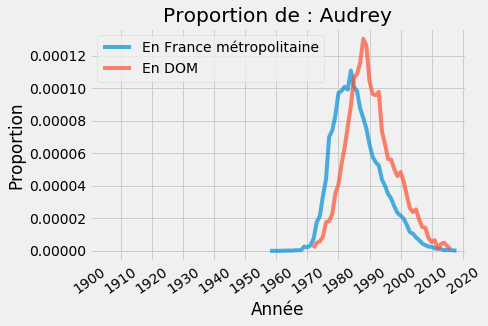

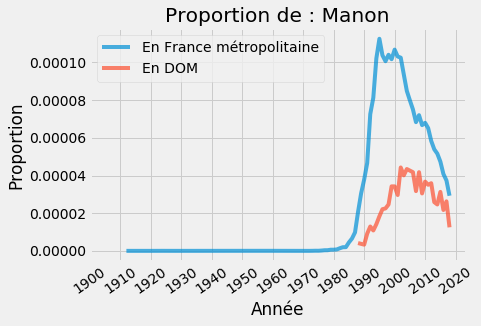

In [50]:
grph_metrop_97('louise')
grph_metrop_97('jean')
grph_metrop_97('yannick')
grph_metrop_97('audrey')
grph_metrop_97('manon')

Cette fois, on dirait bien qu'il y a une influence : les courbes de tendance des DOM sont similaires mais déphasées. Toutefois, nous nous sommes permis de comparer la France métropolitaine d'un côté avec un "groupe" d'îles, séparées de plus de 10 000 km pour certaines, de l'autre. On ne peut pas raisonnablement établir de certitudes quant à ces tendances et un cas par cas serait à faire.

## Machine learning <a id="fifth-bullet"></a>
Les modes sont si imprévisibles qu'un apprentissage automatique ne vaudra pas grand-chose. Par exemple, nous avons vu qu'une personnalité (tristement) célèbre suffit à dicter le comportement des tendances. Par ailleurs, la machine serait incapable de déterminer les nouveaux prénoms de demain.<br/><br/>
Cela dit, nous pouvons nous amuser à anticiper la désuétude de prénoms actuels par <b>régression polynomiale</b>, car après tout, nous avons pu constater que les courbes de tendances sont relativement symétriques, à ceci près que la baisse de tendance est généralement plus progressive que la hausse.<br/><br/>
Des conditions drastiques vont s'appliquer :
    
* Il nous faudra inexorablement restreindre l'intervalle d'étude :
    * en amont, car trop de détails fausseraient les calculs (<b>overfitting</b>).
    * en aval, car la prédiction ne pourra pas raisonnablement se faire sur une longue durée.
* Il nous faudra soigneusement sélectionner les prénoms, car :
    * des tendances à va-et-vients perdront la machine
    * des prénoms aux données trop éparses ne donneront pas de résultat intéressant (<b>underfitting</b>).<br/><br/>
    
<i>Une âme courageuse pourrait créer un modèle sur l'ensemble des courbes une à une, et faire correspondre le début de tendance de la courbe étudiée avec la courbe à l'amorce la plus proche, de manière à déduire la tendance vraisemblable...</i>

In [51]:
from sklearn.preprocessing import StandardScaler #pour centrer les données pour Poly
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


def guess_tendance(prenom="gabriel"):
    prenom = prenom.upper()
    df_pren = cln_pren.query('preusuel == @prenom and annais >= 1970').fillna(0)
    nb_VS_an = df_pren.pivot_table('nombre', index='annais', aggfunc='sum')

    X = nb_VS_an.nombre.index.values
    y = nb_VS_an.nombre.values

    intrvl = np.linspace(X.min()-10, X.max()+30, 100)
    
    #la taille de 0.7 pour l'échantillon d'entraînement est arbitraire : 
    #en dessous, trop peu d'informations pour un calcul efficace (underfitting)
    #au-dessus, le calcul s'adapte trop à ces échantillons particuliers (overfitting)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=1, train_size=0.7)

    fig, ax = plt.subplots()
    
    #Définitions
    poly_model, best_model, mae = dict(), object, None
    
    print('\n%sPrédictions pour le prénom %s%s' % (bold, prenom, n_bold))
    
    #plus de poids aux dernières années de l'échantillon "train" [1, 1, ..., 1, 3, 3, ..., 3]
    sorted_index = np.argsort(X_train)
    X_train = X_train[sorted_index]
    y_train = y_train[sorted_index]
    lg = len(y_train)
    weights = (np.arange(lg) // (lg - int(lg/4))) * 2 + 1
    
    #Voyons quel degré est le plus efficace
    for deg in np.arange(3, 10):
        poly_model[deg] = Pipeline([('scaler', StandardScaler(with_std=False)),
                        ('poly', PolynomialFeatures(degree=deg)),
                      ('linear', LinearRegression(fit_intercept=False))])
        poly_model[deg].fit(X_train[:, np.newaxis], y_train,\
                            linear__sample_weight=weights)
        y_model = poly_model[deg].predict(X_valid[:, np.newaxis])
        
        #Erreur absolue moyenne : plus parlante
        new_mae = mean_absolute_error(y_valid, y_model) 
        #R² : coefficient de détermination : pénalise plus les écarts à la tendance
        new_score = poly_model[deg].score(X_valid[:, np.newaxis], y_valid)
        if mae == None or new_mae < mae:
            best_model, mae = poly_model[deg], new_mae
        print("Degré %d : R² = %f, erreur absolue moyenne : %d" % (deg, new_score, new_mae))
        
    #Traçons les courbes    
    for deg in poly_model.keys(): 
        plot_model = poly_model[deg].predict(intrvl[:, np.newaxis])
        if poly_model[deg] is best_model:
            print("%sMeilleur degré : %d%s" % (bold, deg, n_bold))
            ax.plot(intrvl, plot_model, c='green',\
                    label="*DEG %d*" % deg, zorder=0)
        else:
            ax.plot(intrvl, plot_model, linewidth=1.5, label="deg %d" % deg, zorder=-1)
            
    ax.axhline(y=0, color='k') #axe des abscisses
    ax.scatter(X, y, c='navy', s=20, zorder=1) #échantillons en premier plan

    #On élargit l'intervalle fixé par l'index 
    plt.xlim(X.min()-10, X.max()+10)

    locs = np.arange(1970, 2040, 10)
    plt.xticks(locs)
    plt.xlabel("Année")

    #On empêche de tracer trop haut
    plt.ylim(0, 1.2*y.max())
    plt.ylabel("Nombre de prénoms")

    plt.legend()
    plt.show()
    print('********************')


Prédictions pour le prénom CHARLOTTE
Degré 3 : R² = 0.835482, erreur absolue moyenne : 308
Degré 4 : R² = 0.878779, erreur absolue moyenne : 324
Degré 5 : R² = 0.946634, erreur absolue moyenne : 197
Degré 6 : R² = 0.947244, erreur absolue moyenne : 199
Degré 7 : R² = 0.905100, erreur absolue moyenne : 250
Degré 8 : R² = 0.940274, erreur absolue moyenne : 213
Degré 9 : R² = 0.894310, erreur absolue moyenne : 250
Meilleur degré : 5


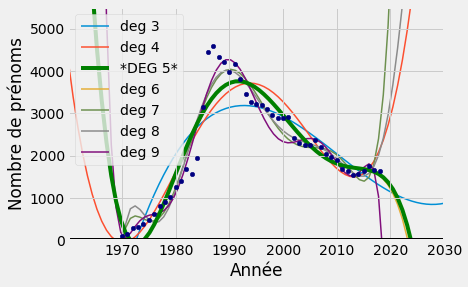

********************

Prédictions pour le prénom ENZO
Degré 3 : R² = 0.618196, erreur absolue moyenne : 1390
Degré 4 : R² = 0.685171, erreur absolue moyenne : 1226
Degré 5 : R² = 0.813216, erreur absolue moyenne : 907
Degré 6 : R² = 0.918476, erreur absolue moyenne : 675
Degré 7 : R² = 0.896493, erreur absolue moyenne : 731
Degré 8 : R² = 0.816510, erreur absolue moyenne : 608
Degré 9 : R² = 0.707455, erreur absolue moyenne : 711
Meilleur degré : 8


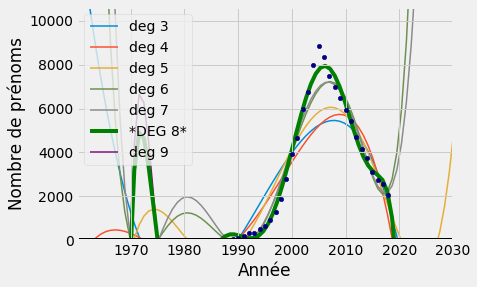

********************

Prédictions pour le prénom FANNY
Degré 3 : R² = 0.962462, erreur absolue moyenne : 112
Degré 4 : R² = 0.946836, erreur absolue moyenne : 146
Degré 5 : R² = 0.980341, erreur absolue moyenne : 96
Degré 6 : R² = 0.981154, erreur absolue moyenne : 93
Degré 7 : R² = 0.973693, erreur absolue moyenne : 120
Degré 8 : R² = 0.979688, erreur absolue moyenne : 99
Degré 9 : R² = 0.960377, erreur absolue moyenne : 111
Meilleur degré : 6


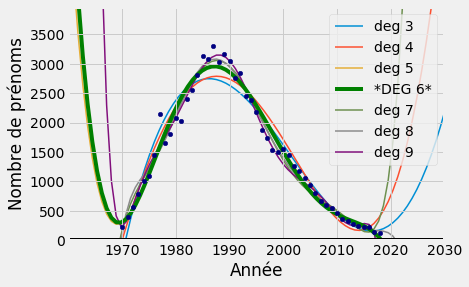

********************

Prédictions pour le prénom EMMANUEL
Degré 3 : R² = 0.993258, erreur absolue moyenne : 95
Degré 4 : R² = 0.994011, erreur absolue moyenne : 76
Degré 5 : R² = 0.993562, erreur absolue moyenne : 119
Degré 6 : R² = 0.993980, erreur absolue moyenne : 100
Degré 7 : R² = 0.994484, erreur absolue moyenne : 59
Degré 8 : R² = 0.995116, erreur absolue moyenne : 65
Degré 9 : R² = 0.988456, erreur absolue moyenne : 141
Meilleur degré : 7


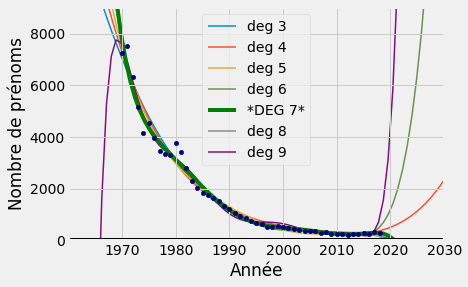

********************


In [52]:
guess_tendance("charlotte")
guess_tendance("enzo")
guess_tendance("fanny")
guess_tendance('emmanuel')

Nous remarquons plusieurs choses :
<ul>
    <li>Même en donnant plus de poids aux dernières années, nous sentons que les courbes sont encore <b>défaitistes en ce qui concerne les tendances à venir</b>. Visuellement, nous sentons que le prénom Charlotte ne sera pas éteint avant 2030. Mais l'algorithme ne présuppose pas.</li>
    <li>La courbe <b>la mieux notée n'est pas forcément celle qui nous aide</b> visuellement. Dans le cas de Fanny, le polynôme de degré 8 tend vers une fin plus logique. D'après ces deux premières remarques, un bidouilleur inventerait peut-être des points à valeur 0 suffisamment loin dans l'avenir pour corriger le tir. </li>
    <li>Comme prévu, <b>les courbes n'ont aucun sens quand on s'éloigne de notre intervalle</b>, ce qui rend notre algorithme extrêmement circonstanciel.</li>
    <li><i>Remarque technique au passage : on voit que le <b>meilleur coefficient de détermination R²</b> ne coïncide pas nécessairement avec l'<b>erreur absolue moyenne</b> la plus basse. Cette dernière a deux avantages : elle est <b>plus parlante</b> (c'est le nombre de prénoms d'écart entre la courbe calculée et les échantillons donnés, en moyenne), et elle est <b>moins drastique</b> : on ne veut pas coller à la courbe à tout prix, mais prolonger les dernières tendances.</i></li>
</ul>        
Peaufinée, la fonction peut trouver des applications. Nous pouvons sans difficulté imaginer remplacer les prénoms par des noms d'articles, les années par des semaines, les départements par des secteurs de vente et voilà : gestion automatique des stocks d'une chaîne de magasins. Mon travail n'est pas vain. Ma vie a un sens.

Autre idée d'application Machine Learning (à venir ?) : créer une fonction qui 
- reçoit un prénom
- indique dans quel département la personne va probablement naître (algo K-Means ?)

Merci à data.gouv.fr de nous avoir fait partager un véritable morceau de culture ! À bientôt pour un nouvel épisode de <b>Fun with Stats !</b>